# TKO_7093 - Statistical Data Analysis Project
## Group 160

## Team Members

| Name                      | Student ID|
| :--------                 | :-------: |
| Ayana Kotuwegoda Guruge   | 2406865   |
| Sheheryar Wahidi          | 2413773   |
| Yagya Yadav               | 2409273   |

---

## Data Preparation

In [57]:
#Needed libraries
#from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

In [11]:
#drive.mount('/content/drive')
#!ls /content/drive/


### Following steps are carried out for the data preparation:

This step is for checking the dataset, cleaning and structuring for further analysis (qualititative). 

* Data loaded from habits.data into a DataFrame matching the variables.
* Missing values are checked and not removed.
* Codes are converted into readable lables.
* Checking all demographic values for sensible values.
* Checking the validity of the ranges.
* Replacing the invalid values of the variables accordingly.

In [12]:
# Load the dataset from Path
data_path = "habits.data"
columns = ['kohde', 'jasen', 'pvknro', 'sp', 'ASALUE', 'IKAL1', 'A1', 'A2', 'A3', 'A4', 'A5']
df = pd.read_csv(data_path, sep=";", header=0, usecols=columns, na_values=['?'])

# Initial exploration of the dataset    
df.head()
df.shape
df.info()
df.describe()

# Display the first few rows of the dataframe
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745 entries, 0 to 744
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kohde   745 non-null    int64  
 1   jasen   745 non-null    int64  
 2   pvknro  745 non-null    int64  
 3   sp      745 non-null    int64  
 4   ASALUE  745 non-null    float64
 5   IKAL1   745 non-null    int64  
 6   A1      741 non-null    object 
 7   A2      737 non-null    object 
 8   A3      733 non-null    object 
 9   A4      736 non-null    object 
 10  A5      703 non-null    float64
dtypes: float64(2), int64(5), object(4)
memory usage: 64.2+ KB


,kohde,jasen,pvknro,sp,ASALUE,IKAL1,A1,A2,A3,A4,A5
0,50002,1,1,1,1.0,49,0,560,0,80,1.0
1,50002,1,2,1,1.0,49,380,450,10,0,1.0
2,50003,1,1,2,2.0,41,0,470,30,100,1.0
3,50003,1,2,2,2.0,41,0,550,0,0,1.0
4,50004,2,1,1,1.0,62,640,410,0,0,1.0


* Structure was checked because according to the instructions given as there are multiple rows of the same person.
* This is more to show that one person can be recorded for more than one day. Changes will be done in task 1
    * 6 columns (Household ID, Person ID, day type, sex, living area, age group) are demographic variables.
    * 5 columns (A1-A5) which are activity variables.
* A1 to A4 variables are shown as objects where it should be in numerics since it is the time spent in activities in minutes according to the text file. This is due to mixed formatting or missing values or both.
* The appearance of A5 variable (Visiting library) in float which aslo should be in numerics.

In [14]:
# Checking for missing values
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
kohde      0
jasen      0
pvknro     0
sp         0
ASALUE     0
IKAL1      0
A1         4
A2         8
A3        12
A4         9
A5        42
dtype: int64


* It shows that there some missing values in the activity variables but no missing values in the demographic variables.

* Number of missing values of activity columns:
    * A1 - 4
    * A2 - 8
    * A3 - 12
    * A4 - 9
    * A5 - 42 

* Missing values are kept as NaN.
* Missing values are not always "0 minutes spent"/" no activity". It can also mean that the data entry was missed to be recorded or an error. Therefore, it is better to keep them as NaN value guessing or maintaining as 0 assuming that there was no activity.

### Data Type Conversion and Cleaning

In [15]:
# Replace '?' with NaN for consistent value handling
df_clean = df.replace('?', np.nan)

# Convert demographic variables to appropriate types respectrively (all numeric in this case)
df_clean['kohde'] = pd.to_numeric(df_clean['kohde'], errors='coerce')
df_clean['jasen'] = pd.to_numeric(df_clean['jasen'], errors='coerce')
df_clean['pvknro'] = pd.to_numeric(df_clean['pvknro'], errors='coerce')
df_clean['sp'] = pd.to_numeric(df_clean['sp'], errors='coerce')
df_clean['IKAL1'] = pd.to_numeric(df_clean['IKAL1'], errors='coerce')
df_clean['ASALUE'] = pd.to_numeric(df_clean['ASALUE'], errors='coerce')

# Activity variables converting to numeric, handling time format data
for col in ['A1', 'A2', 'A3', 'A4', 'A5']:
    # A1-A4 are minutes and A5 in yes/no format, convert accordingly
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

print("Data types after conversion:")
print(df_clean.dtypes)
print("\nMissing values per column")
print(df_clean.isnull().sum())
print("\nDataFrame shape:", df_clean.shape)

Data types after conversion:
kohde       int64
jasen       int64
pvknro      int64
sp          int64
ASALUE    float64
IKAL1       int64
A1        float64
A2        float64
A3        float64
A4        float64
A5        float64
dtype: object

Missing values per column
kohde      0
jasen      0
pvknro     0
sp         0
ASALUE     0
IKAL1      0
A1        85
A2        88
A3        94
A4        91
A5        42
dtype: int64

DataFrame shape: (745, 11)


The above conversions will ensure that later calculations will be correct since all the incorrect and missing values are now treated as missing values (NaN). This was done using 'errors="coerce"' where cleaning up will not create new missing data but changing the already existing ones.

In [17]:
# Checking for ranges from the text file for variables pvknro, sp, ASALUE, IKAL1
allowed_ranges = {
    'pvknro' : {1,2},
    'sp' : {1,2},
    'ASALUE' : {1,2,3},
    'IKAL1' : set(range(1,10)), # 1 to 9 
    'A5' : {1,2} # yes/no  
}

for col, valid_values in allowed_ranges.items():
    unique_values = set(df[col].dropna().unique())
    invalid_values = unique_values - valid_values
    print(f"{col}:")
    print(f"Unique values found: {sorted(unique_values)}")
    if invalid_values:
        print(f"Invalid values found: {sorted(invalid_values)}")
    else:
        print("All values are valid.")
    print()

pvknro:
Unique values found: [np.int64(1), np.int64(2)]
All values are valid.

sp:
Unique values found: [np.int64(1), np.int64(2)]
All values are valid.

ASALUE:
Unique values found: [np.float64(1.0), np.float64(2.0), np.float64(3.0)]
All values are valid.

IKAL1:
Unique values found: [np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np.int64(70),

* Above verification is done because the missing values per column increased after converting the data types for the correct ones. 
    * pvknro, sp, ASALUE are all valid.
    * IKAL1 which are age ranges which should only be from 1-9 have values more than 20. 
        * Therefore, it is assumed that the ages are entered insted of the relevant age group number.
    * A5 should be having yes or no entries with either 1 or 2 to depict that the library was visited or not. But there are some float values entered. 
        * Therefore, it is assumed that those float values are the number of hours spent in the library which will then be entered as 1 (yes) to which it will be changed.



#### Data correction

Following steps are done in this phase.
* Raw data frame will be created for reference.
* All rows in the A5 will be assumed and conmverted to 1 and 2 (yes or no).
    * To avoid losing information, the original A5 variable was kept unchanged and a new
binary variable (A5_binary) was created for analysis.
    * After conversion, A5_binary contains only valid categories (yes, no, and missing).
* All IKAL1 ranges will be preserved in the raw DataFrame as reference. But the age groups will be sorted into 1-9 ranges as shown in the data.text file for clearer depictions in the coming tasks. This is done in the cleaned DataFrame.

In [26]:
df_raw = df.copy()

# Age groups based on IKAL1
bins = [10, 14, 19, 24, 34, 44, 54, 64, 74, float('inf')]
labels = ['10–14', '15–19', '20–24', '25–34',
          '35–44', '45–54', '55–64', '65–74', '75+']

df_clean['age_group'] = pd.cut(
    df_clean['IKAL1'],
    bins=bins,
    labels=labels,
    right=True
).astype('category')

df_clean['IKAL1'].describe()
df_clean['age_group'].value_counts(dropna=False).sort_index()

print("\nAge group check:")
print(df_clean[['IKAL1', 'age_group']].head(10))

def a5_to_binary(x):
    if pd.isna(x):
        return np.nan
    if x == 1 or x > 2:
        return 1  # yes
    if x == 2 or x == 0:
        return 2  # no
    return np.nan

# Create a NEW cleaned column (do NOT overwrite A5)
df_clean["A5_binary"] = df_clean["A5"].apply(a5_to_binary).astype("category")

# Verify: compare original vs cleaned
print("\n\nOriginal A5:")
print(df_clean["A5"].value_counts(dropna=False).head(10))

print("\nA5_binary distribution:")
print(df_clean["A5_binary"].value_counts(dropna=False))

df_clean.head()



Age group check:
   IKAL1 age_group
0     49     45–54
1     49     45–54
2     41     35–44
3     41     35–44
4     62     55–64
5     62     55–64
6     46     45–54
7     46     45–54
8     33     25–34
9     33     25–34


Original A5:
A5
1.0      474
2.0      209
NaN       42
0.0       17
120.0      1
60.0       1
420.0      1
Name: count, dtype: int64

A5_binary distribution:
A5_binary
 1.0    477
 2.0    226
NaN      42
Name: count, dtype: int64


,kohde,jasen,pvknro,sp,ASALUE,IKAL1,A1,A2,A3,A4,A5,age_group,A5_binary
0,50002,1,1,1,1.0,49,0.0,560.0,0.0,80.0,1.0,45–54,1.0
1,50002,1,2,1,1.0,49,380.0,450.0,10.0,0.0,1.0,45–54,1.0
2,50003,1,1,2,2.0,41,0.0,470.0,30.0,100.0,1.0,35–44,1.0
3,50003,1,2,2,2.0,41,0.0,550.0,0.0,0.0,1.0,35–44,1.0
4,50004,2,1,1,1.0,62,640.0,410.0,0.0,0.0,1.0,55–64,1.0


**Mapping and making sp, pvknro, ASALUE, IKAL1, A5 will be converted to categorical data types since will help in the analysis and the data to be treated correctly in the descriptive statistics and statistical test.**

In [27]:
# Convert coded variables to categorical with labels

df_clean["sp"] = df_clean["sp"].map({1: "Male", 2: "Female"}).astype("category")

df_clean["pvknro"] = df_clean["pvknro"].map(
    {1: "Weekday", 2: "Weekend"}
).astype("category")

df_clean["ASALUE"] = df_clean["ASALUE"].map(
    {1: "City", 2: "Municipality", 3: "Rural"}
).astype("category")


df_clean[["sp", "pvknro", "ASALUE", "age_group", "A5_binary"]].head()
df_clean.dtypes


kohde           int64
jasen           int64
pvknro       category
sp           category
ASALUE       category
IKAL1           int64
A1            float64
A2            float64
A3            float64
A4            float64
A5            float64
age_group    category
A5_binary    category
dtype: object

## Task 1 - Characterizing Individuals in the data

Each entry in the level is given in the data file is person-day level entries. But to keep the observations per individual has to be identified from the household ID and the person ID (kohde and jasen)

In [29]:
persons = df_clean.drop_duplicates(subset=['kohde', 'jasen'])

print("df_clean shape:", df_clean.shape)
print("persons shape:", persons.shape)


df_clean shape: (745, 13)
persons shape: (378, 13)


In [30]:
print("Number of individuals:", persons.shape[0])
print("Number of households:", persons["kohde"].nunique())


Number of individuals: 378
Number of households: 378


The above result shows that there are only 378 individuals in the data set. But some are duplicated because of the due to both weekend and weekday entries. 
745 is a count of person-day observations.

#### Gender, Age group, Living environment distribution

        Count  Percentage (%)
sp                           
Female    196            51.9
Male      182            48.1

Age Group Distribution:
           Count  Percentage (%)
age_group                       
10–14          0             0.0
15–19          0             0.0
20–24         12             3.2
25–34         57            15.1
35–44         64            16.9
45–54         81            21.4
55–64         93            24.6
65–74         44            11.6
75+           27             7.1

Living Environment Distribution:
              Count  Percentage (%)
ASALUE                             
City            240            63.5
Rural            80            21.2
Municipality     58            15.3


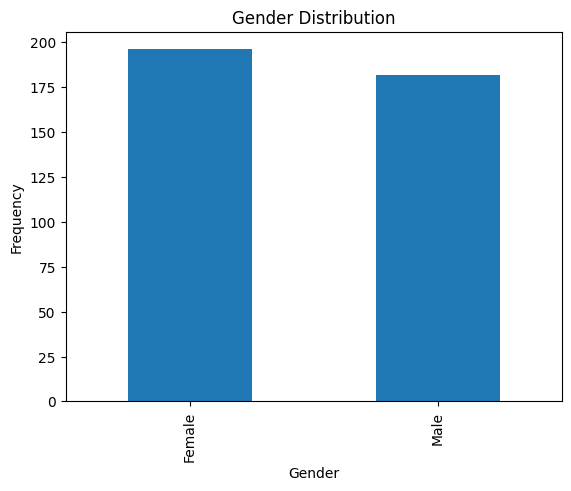

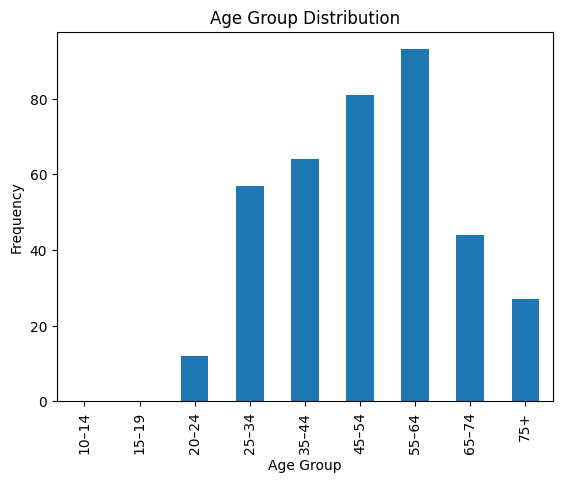

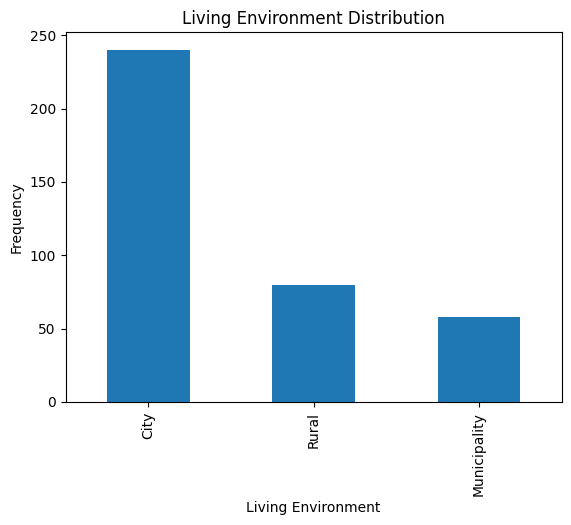

In [40]:
# Gender distribution
gender_counts = persons["sp"].value_counts()
gender_pct = (gender_counts / len(persons) * 100).round(1)

pd.DataFrame({
    "Count": gender_counts,
    "Percentage (%)": gender_pct
})
print(pd.DataFrame({
    "Count": gender_counts,
    "Percentage (%)": gender_pct
}))

age_counts = persons["age_group"].value_counts().sort_index()
age_pct = (age_counts / len(persons) * 100).round(1)

pd.DataFrame({
    "Count": age_counts,
    "Percentage (%)": age_pct
})

print("\nAge Group Distribution:")
print(pd.DataFrame({
    "Count": age_counts,
    "Percentage (%)": age_pct
}))

env_counts = persons["ASALUE"].value_counts()
env_pct = (env_counts / len(persons) * 100).round(1)

pd.DataFrame({
    "Count": env_counts,
    "Percentage (%)": env_pct
})

print("\nLiving Environment Distribution:")
print(pd.DataFrame({
    "Count": env_counts,
    "Percentage (%)": env_pct
}))

gender_counts.plot(kind="bar", title="Gender Distribution")
plt.ylabel("Frequency")
plt.xlabel("Gender")
plt.show()

age_counts.plot(kind="bar", title="Age Group Distribution")
plt.ylabel("Frequency")
plt.xlabel("Age Group")
plt.show()

env_counts.plot(kind="bar", title="Living Environment Distribution")
plt.ylabel("Frequency")
plt.xlabel("Living Environment")
plt.show()



- The analysis is based on individual-level data, where each person appears only once.
- The gender distribution is fairly balanced, with females making up about 52% of the sample
  and males about 48%.
- Most individuals belong to middle-aged groups, especially those aged 45–64 years, while
  younger and oldest age groups are less represented.
- The majority of individuals live in cities, with smaller proportions living in rural areas
  or municipalities.

In [42]:
household_sizes = persons.groupby("kohde").size()

household_sizes.describe()
household_sizes.value_counts().sort_index()
print("Household Sizes Description:")
print(household_sizes.describe())

Household Sizes Description:
count    378.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
dtype: float64


* Household size was examined by counting the number of individuals per household.
* The results show that all households in the dataset consist of a single individual.
* As a result, household-level averages correspond directly to individual-level observations in the subsequent analysis.


## Task 2 – Average daily time spent on activities

### Estimating how much time on average the Finnish households spend on each activity.

* This is done in the household-level.
* Each household has one individual.
* Therefore, the averages of households are equal to the averages of individuals.
* Descriptve statistics are used (mean, standard deviation and intepretation)
* Only activity variables are used (A1-A4)

In [49]:
activity_cols = ['A1', 'A2', 'A3', 'A4']

df_clean[activity_cols].describe()


,A1,A2,A3,A4
count,660.000000,657.000000,651.000000,654.000000
mean,120.606061,520.000000,47.983103,48.495413
std,208.142145,100.708617,64.043457,58.558586
min,0.000000,70.000000,0.000000,0.000000
25%,0.000000,465.000000,0.000000,0.000000
50%,0.000000,515.000000,30.000000,0.000000
75%,200.000000,580.000000,70.000000,100.000000
max,1050.000000,900.000000,474.000000,240.000000


* Above table shows a descriptive statistics for the daily time spent in activities in minutes.
* Most time is taken for sleep (A2) as an average. (520 mins)
* Working (A1) is varied and shows that not all inviduals work everyday.
* Reading (A3) and Dining (A4) have low averages and medians of 0. This means that they are occasionally done rather than daily activities.

          A1     A2    A3     A4
kohde                           
50002  190.0  505.0   5.0   40.0
50003    0.0  510.0  15.0   50.0
50004  320.0  480.0  36.0   54.0
50005    0.0  545.0  46.0  108.0
50006    0.0  535.0  31.0   45.0


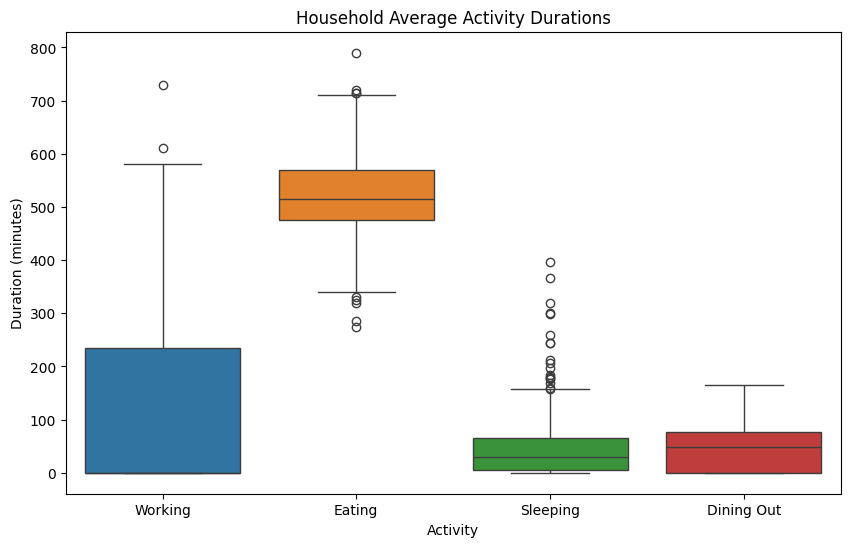

In [56]:
household_activity_mean = (
    df_clean.groupby('kohde')[activity_cols]
    .mean()
)

print(household_activity_mean.head())

plt.figure(figsize=(10, 6))
sns.boxplot(data=household_activity_mean)
plt.title("Household Average Activity Durations")
plt.ylabel("Duration (minutes)")
plt.xlabel("Activity")

#rename x-ticks for clarity
plt.xticks(ticks=range(len(activity_cols)), labels=['Working', 'Eating', 'Sleeping', 'Dining Out'])
plt.show()

Following observations are done in the boxplot where aveerage daily times for different activities are varied accross different households.
- Sleeping is the most consistent activity, with high average durations and relatively little
  variation between households.
- Working shows much larger variation, including many low or zero values, indicating that not
  everyone works every day or for the same amount of time.
- Reading and dining out have much lower typical durations, suggesting these activities are
  done less frequently and for shorter periods.
- A few households appear as outliers, especially for working and sleeping, reflecting unusually
  high time use on those activities.


### Statistical estimations of average time spent on activities

* A 95% confidence interval is used. This is assuming the following:
    * Central limit theorom where large enough sample size is considered.
    * And taking household independantly.

In [60]:
conint_results = []

n = len(household_activity_mean)

for col in activity_cols:
    mean = household_activity_mean[col].mean()
    std = household_activity_mean[col].std(ddof=1)
    se = std / np.sqrt(n)
    conint_low, conint_high = stats.t.interval(
        0.95, df=n-1, loc=mean, scale=se
    )
    conint_results.append((mean, conint_low, conint_high))

conint_df = pd.DataFrame(
    conint_results,
    index=activity_cols,
    columns=['Mean', '95% CI Lower', '95% CI Upper']
)
conint_df


,Mean,95% CI Lower,95% CI Upper
A1,121.646884,106.590725,136.703043
A2,520.237389,512.625010,527.849768
A3,48.596439,42.511462,54.681416
A4,49.130952,44.721818,53.540087


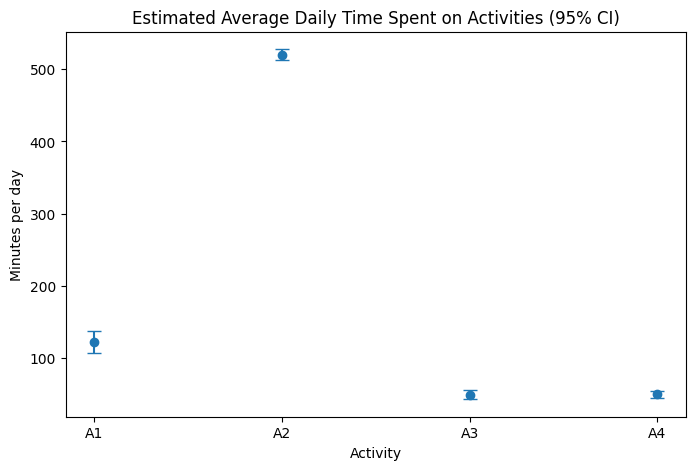

In [61]:
# Error bar plot for mean and 95% CI
means = conint_df["Mean"]
lower = conint_df["95% CI Lower"]
upper = conint_df["95% CI Upper"]

yerr = [means - lower, upper - means]

plt.figure(figsize=(8, 5))
plt.errorbar(conint_df.index, means, yerr=yerr, fmt="o", capsize=5)
plt.ylabel("Minutes per day")
plt.xlabel("Activity")
plt.title("Estimated Average Daily Time Spent on Activities (95% CI)")
plt.show()


- Sleeping (A2) has the highest estimated average time and a very narrow confidence
  interval, indicating a stable and consistent daily pattern across households.
- Working (A1) shows a lower average time and a wider confidence interval, reflecting
  substantial variation in working time between households.
- Reading (A3) and dining out (A4) have much lower estimated averages, with confidence
  intervals close to zero, confirming that these activities are not performed daily by
  most households.

Overall, the confidence intervals highlight clear differences in time allocation across
activities while accounting for sampling uncertainty.